# Customer churn prediction

Customers began to leave Beta-Bank. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of agreements with the bank.

Build a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

I download the necessary libraries.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle


#disable warnings
import warnings
warnings.filterwarnings('ignore')

Loading and evaluation of the dataset.

In [76]:
df = pd.read_csv('/datasets/Churn.csv')
display(df.head(5))
display(df.tail(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Evaluation of columns and types of data presented.

In [77]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Number of passes.

In [78]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Check for duplicates.

In [79]:
df.duplicated().sum()

0

Let's evaluate the correlation table.

In [80]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Evaluate the correlation matrix.

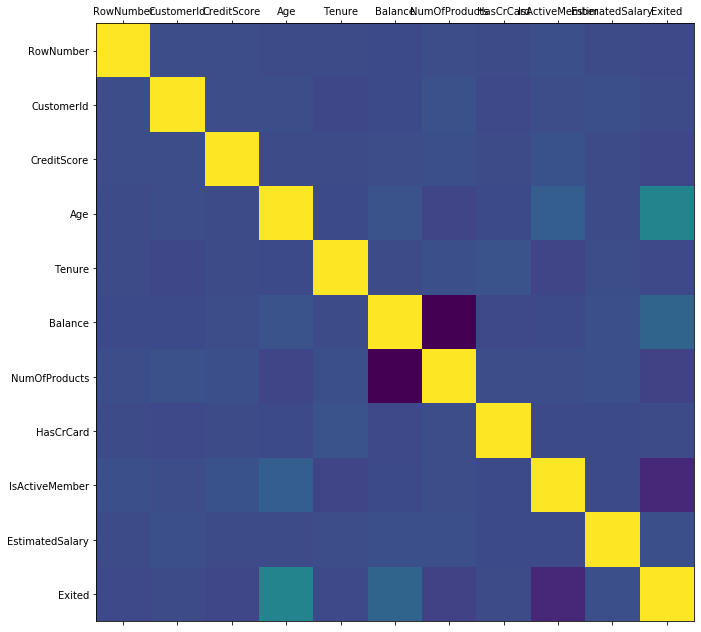

In [81]:
def plot_corr(df, size=11):
  corr = df.corr()
  fig, ax = plt.subplots(figsize=(size,size))
  ax.matshow(corr)
  plt.xticks(range(len(corr.columns)), corr.columns)
  plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(df)

It is noticeable that there are no significant relationships. Great, the model will not encounter serious problems.

Let's remove the columns that have no meaning for the model.

In [82]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

Evaluate the distribution of men and women.

In [83]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

I see some imbalance.

Estimation of geographical distribution.

In [84]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Replacing empty values in the column with the duration of cooperation with the bank using SimpleImputer from the sklearn library.

In [85]:
df['Tenure'] = df['Tenure'].replace(np.NaN, None).astype(int,errors='ignore').astype(object)
imputer = SimpleImputer(strategy='constant')
imp_data = pd.DataFrame(imputer.fit_transform(df))
imp_data.columns = df.columns

#Проверка работоспособности
df['Tenure'].isnull().sum()

0

Converting categorical values.

In [86]:
df = pd.get_dummies(df, drop_first=True)
df

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,...,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10
0,619,42,0.00,1,1,1,101348.88,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,3,1,0,113931.57,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,699,39,0.00,2,0,0,93826.63,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,0.00,2,1,0,96270.64,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9996,516,35,57369.61,1,1,1,101699.77,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9997,709,36,0.00,1,0,1,42085.58,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9998,772,42,75075.31,2,1,0,92888.52,1,1,0,...,0,0,1,0,0,0,0,0,0,0


I divide the sample into training, validation and test samples in proportion 0.6 + 0.2 + 0.2.

In [87]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

print('Training set size:', X_train.shape[0])
print('Validating set size:', X_valid.shape[0])
print('Test set size:',X_test.shape[0])

Training set size: 6000
Validating set size: 2000
Test set size: 2000


In [88]:
sc = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
sc.fit(X_train[numeric])

X_train[numeric] = sc.transform(X_train[numeric])
X_valid[numeric] = sc.transform(X_valid[numeric])
X_test[numeric] = sc.transform(X_test[numeric])

###### Conclusion:

At the moment, the dataset has been researched, a number of empty values were found in the Tenure column (they were filled using SimpleImputer), no duplicates were found, the correlation matrix did not reveal any serious relationships, the features were coded and standardized using the StandardScaler, the sample was divided into training, validation and testing.

## Task research

Let's see which model is best for solving the problem. Let's start with a random forest with standard parameters, evaluate the akurasi and the F1 metric.

In [89]:
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.838
F1_Score is: 0.49845201238390097


array([[1515,   62],
       [ 262,  161]])

The accuracy is at a high level, F1 does not reach the required values. Let's test logistic regression.

In [90]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))

confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.789
F1_Score is: 0.2673611111111111


array([[1501,   76],
       [ 346,   77]])

###### Conclusion:

As you can see, the random forest model shows the best results. We will improve our results.

## Struggling with imbalance

Let's explore through the loop the most appropriate values for the random forest.

In [91]:
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = accuracy_score(predictions, y_valid)
    fscore = f1_score(y_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    print('------------------------------------------------------')

Depth:     1       |   Estimators:     1
Accuracy: 0.6785   |   F1_Score: 0.4819
------------------------------------------------------
Depth:     1       |   Estimators:    51
Accuracy: 0.7375   |   F1_Score: 0.4937
------------------------------------------------------
Depth:     1       |   Estimators:   101
Accuracy: 0.7345   |   F1_Score: 0.5238
------------------------------------------------------
Depth:    11       |   Estimators:     1
Accuracy: 0.7665   |   F1_Score: 0.5353
------------------------------------------------------
Depth:    11       |   Estimators:    51
Accuracy: 0.8345   |   F1_Score: 0.6026
------------------------------------------------------
Depth:    11       |   Estimators:   101
Accuracy: 0.8365   |   F1_Score: 0.5998
------------------------------------------------------
Depth:    21       |   Estimators:     1
Accuracy: 0.7610   |   F1_Score: 0.4442
------------------------------------------------------
Depth:    21       |   Estimators:    51
Accurac

Excellent, with a maximum tree depth of 11 and a maximum number of trees of 51, the F1 metric reached a value of 0.6034.

Perhaps the indicators can be optimized by increasing or decreasing the sample.

Let's start with upsampling.

In [92]:
def upsampling(features, target, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled


for repeat in range(1,10,1):
    X_upsampled, y_upsampled = upsampling(X_train, y_train, repeat)

    model = RandomForestClassifier(random_state=12345)
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}".format(f1_score(y_valid, predictions),repeat))

F1_Score: 0.498  |   Repeats :     1
F1_Score: 0.528  |   Repeats :     2
F1_Score: 0.508  |   Repeats :     3
F1_Score: 0.548  |   Repeats :     4
F1_Score: 0.533  |   Repeats :     5
F1_Score: 0.502  |   Repeats :     6
F1_Score: 0.524  |   Repeats :     7
F1_Score: 0.526  |   Repeats :     8
F1_Score: 0.532  |   Repeats :     9


Increasing the sample did not improve the results. Let's try to reduce it.

In [93]:
def downsampling(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

for i in np.arange(0.03, 0.31, 0.03):
    X_downsampled, y_downsampled = downsampling(X_train, y_train, i)
    model = RandomForestClassifier(random_state=12345)
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}".format(f1_score(y_valid, predictions), i))

F1_Score: 0.375  |  Fractions : 0.030
F1_Score: 0.440  |  Fractions : 0.060
F1_Score: 0.472  |  Fractions : 0.090
F1_Score: 0.488  |  Fractions : 0.120
F1_Score: 0.505  |  Fractions : 0.150
F1_Score: 0.541  |  Fractions : 0.180
F1_Score: 0.535  |  Fractions : 0.210
F1_Score: 0.558  |  Fractions : 0.240
F1_Score: 0.533  |  Fractions : 0.270
F1_Score: 0.566  |  Fractions : 0.300


###### Conclusion:

With the maximum tree depth - 11 and the maximum number of trees - 51, the F1 metric was brought to the desired level. Metric optimization cannot be achieved by upsampling or downsampling.

## Model testing

Testing the best model on a test set.

In [94]:
model = RandomForestClassifier(n_estimators = 51, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_test, predicted_valid))

Accuracy is: 0.843
F1_Score is: 0.6244019138755981


Remarkably, the value of F1 has grown even more. Let's study the ROC curve.

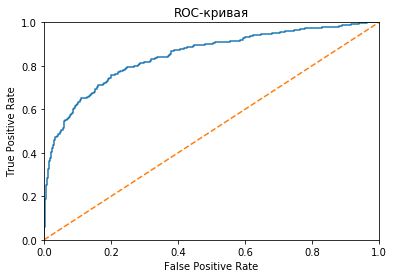

In [95]:
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [96]:
auc_roc = roc_auc_score(y_test, probabilities_one_test)

print('Значение AUC-ROC:', auc_roc)

Значение AUC-ROC: 0.8470336138011965


###### Conclusion:

The value of AUC-ROC quite strongly exceeds the level of 0.5, which means that the resulting model is significantly different from the random model for the better.

## General conclusion:

The presented dataset was studied and prepared to create the desired model. Random forest and logistic regression models were studied, as a result of which it was revealed that the random forest model is the most suitable for this task. As a result of the enumeration of the parameters, it was possible to achieve the F1 indicator, which exceeds the threshold value. On the test sample, the F1 value increased even more, and the AUC-ROC value significantly exceeded 0.5 (the level of the random model). The model has proven to be excellent.